In [ ]:
import os
try:
    from google.colab import drive
    drive.mount('/content/gdrive')

    DRIVE_PATH = '/content/gdrive/My\ Drive/VMG/DesnowNet'
    DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
    if not os.path.exists(DRIVE_PYTHON_PATH):
      %mkdir $DRIVE_PATH

    ## the space in `My Drive` causes some issues,
    ## make a symlink to avoid this
    SYM_PATH = '/content/VMG'
    if not os.path.exists(SYM_PATH):
      !ln -s $DRIVE_PATH $SYM_PATH

    running_in_colab = True

    # We already mounted in our google drive.
    # Enter the foler where you put files in:
    %cd '/content/VMG'

    # Current working directory:
    !pwd

    # What files are there:
    !ls
except ModuleNotFoundError:
    print(
        "I guess you are running locally. If you get this message in Colab, check the files."
    )

Mounted at /content/gdrive
/content/gdrive/My Drive/VMG/DesnowNet
/content/gdrive/My Drive/VMG/DesnowNet
DesnowNet.ipynb  DeSnowNet.ipynb  snow	Snow100K-training.tar.gz  Snow-train  test  test2


In [ ]:
# !wget "https://desnownet.s3.amazonaws.com/dataset_synthetic/train/Snow100K-training.tar.gz"

In [ ]:
# !wget "https://desnownet.s3.amazonaws.com/dataset_synthetic/test/Snow100K-testset.tar.gz"

In [ ]:
import tarfile
file = tarfile.open("Snow100K-training.tar.gz")
file.extractall("Snow-train")
file.close()

In [ ]:
import torch
from torch.utils.data import Dataset , DataLoader
import torchvision
import torchvision.transforms.functional as tf
import cv2
from torchvision import transforms, utils
image = cv2.imread('lake.jpg')
class SnowDataset(Dataset):
  def __init__(self):
    self.gt  = "snow/gt/"
    self.mask = "snowl/mask/"
    self.synthetic = "snow/synthetic/"
    self.image_names = os.listdir("snow/gt/")

  def __len__(self):
    return len(self.image_names)

  def transform(self, origImg, maskImg, snowImg):
    origImg = tf.to_tensor(origImg)
    maskImg = tf.to_tensor(maskImg)
    snowImg = tf.to_tensor(snowImg)

    i, j, h, w = transforms.RandomCrop.get_params(origImg, output_size=(64, 64))
    origImg = tf.crop(origImg, i, j, h, w)
    maskImg = tf.crop(maskImg, i, j, h, w)
    snowImg = tf.crop(snowImg, i, j, h, w)
    return origImg, maskImg, snowImg

  def __getitem__(self, idx):
    image_name = self.image_names[idx]
    originalImagePath = os.path.join(self.gt, image_name)
    maskPath          = os.path.join(self.mask, image_name)
    snowImagePath     = os.path.join(self.synthetic, image_name)

    originalImage = cv2.imread(originalImagePath)
    maskImage     = cv2.imread(maskPath)
    snowImage     = cv2.imread(snowImagePath)

    originalImage, maskImage, snowImage = self.transform(originalImage, maskImage, snowImage)
    sample = {'snow': snowImage, 'gt': originalImage, 'mask':maskImage}

    return sample


In [ ]:
train_dataset = SnowDataset()
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)

In [ ]:
import matplotlib.pyplot as plt
def visualise(dataloader):
  dataiter = iter(dataloader)

  sample = next(dataiter)
  snowImgs = sample['snow']
  maskImgs = sample['mask']
  origImgs = sample['gt']

  plt.figure()
  grid = utils.make_grid(snowImgs)
  plt.imshow(grid.numpy().transpose((1, 2, 0)))
  plt.show()
  plt.figure()
  grid = utils.make_grid(maskImgs)
  plt.imshow(grid.numpy().transpose((1, 2, 0)))
  plt.show()
  plt.figure()
  grid = utils.make_grid(origImgs)
  plt.imshow(grid.numpy().transpose((1, 2, 0)))
  plt.show()


visualise(train_dataloader)

NameError: name 'train_dataloader' is not defined

In [ ]:
import torch.nn as nn
import torch.nn.functional as f

factor=2
class BasicConv2d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride, padding=0):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(
            in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(out_planes, eps=0.001)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Mixed3a(nn.Module):
    def __init__(self):
        super(Mixed3a, self).__init__()
        self.maxpool = nn.MaxPool2d(3, stride=1, padding=1)
        self.conv = BasicConv2d(32//factor, 48//factor, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x0 = self.maxpool(x)
        x1 = self.conv(x)
        out = torch.cat((x0, x1), 1)
        return out


class Mixed4a(nn.Module):
    def __init__(self):
        super(Mixed4a, self).__init__()

        self.branch0 = nn.Sequential(
            BasicConv2d(80//factor, 32//factor, kernel_size=1, stride=1),
            BasicConv2d(32//factor, 48//factor, kernel_size=3, stride=1, padding=1)
        )

        self.branch1 = nn.Sequential(
            BasicConv2d(80//factor, 32//factor, kernel_size=1, stride=1),
            BasicConv2d(32//factor, 32//factor, kernel_size=(1, 7), stride=1, padding=(0, 3)),
            BasicConv2d(32//factor, 32//factor, kernel_size=(7, 1), stride=1, padding=(3, 0)),
            BasicConv2d(32//factor, 48//factor, kernel_size=(3, 3), stride=1, padding=1)
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        out = torch.cat((x0, x1), 1)
        return out


class Mixed5a(nn.Module):
    def __init__(self):
        super(Mixed5a, self).__init__()
        self.conv = BasicConv2d(96//factor, 96//factor, kernel_size=3, stride=1, padding=1)
        self.maxpool = nn.MaxPool2d(3, stride=1, padding=1)

    def forward(self, x):
        x0 = self.conv(x)
        x1 = self.maxpool(x)
        out = torch.cat((x0, x1), 1)
        return out


class InceptionA(nn.Module):
    def __init__(self):
        super(InceptionA, self).__init__()
        self.branch0 = BasicConv2d(192//factor, 48//factor, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(192//factor, 32//factor, kernel_size=1, stride=1),
            BasicConv2d(32//factor, 48//factor, kernel_size=3, stride=1, padding=1)
        )

        self.branch2 = nn.Sequential(
            BasicConv2d(192//factor, 32//factor, kernel_size=1, stride=1),
            BasicConv2d(32//factor, 48//factor, kernel_size=3, stride=1, padding=1),
            BasicConv2d(48//factor, 48//factor, kernel_size=3, stride=1, padding=1)
        )

        self.branch3 = nn.Sequential(
            nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False),
            BasicConv2d(192//factor, 48//factor, kernel_size=1, stride=1)
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class ReductionA(nn.Module):
    def __init__(self):
        super(ReductionA, self).__init__()
        self.branch0 = BasicConv2d(192//factor, 192//factor, kernel_size=3, stride=1, padding=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(192//factor, 96//factor, kernel_size=1, stride=1),
            BasicConv2d(96//factor, 112//factor, kernel_size=3, stride=1, padding=1),
            BasicConv2d(112//factor, 128//factor, kernel_size=3, stride=1, padding=1)
        )

        self.branch2 = nn.MaxPool2d(3, stride=1, padding=1)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        out = torch.cat((x0, x1, x2), 1)
        return out


class InceptionB(nn.Module):
    def __init__(self):
        super(InceptionB, self).__init__()
        self.branch0 = BasicConv2d(512//factor, 192//factor, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(512//factor, 96//factor, kernel_size=1, stride=1),
            BasicConv2d(96//factor, 112//factor, kernel_size=(1, 7), stride=1, padding=(0, 3)),
            BasicConv2d(112//factor, 128//factor, kernel_size=(7, 1), stride=1, padding=(3, 0))
        )

        self.branch2 = nn.Sequential(
            BasicConv2d(512//factor, 96//factor, kernel_size=1, stride=1),
            BasicConv2d(96//factor, 96//factor, kernel_size=(7, 1), stride=1, padding=(3, 0)),
            BasicConv2d(96//factor, 112//factor, kernel_size=(1, 7), stride=1, padding=(0, 3)),
            BasicConv2d(112//factor, 112//factor, kernel_size=(7, 1), stride=1, padding=(3, 0)),
            BasicConv2d(112//factor, 128//factor, kernel_size=(1, 7), stride=1, padding=(0, 3))
        )

        self.branch3 = nn.Sequential(
            nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False),
            BasicConv2d(512//factor, 64//factor, kernel_size=1, stride=1)
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class ReductionB(nn.Module):
    def __init__(self):
        super(ReductionB, self).__init__()

        self.branch0 = nn.Sequential(
            BasicConv2d(512//factor, 96//factor, kernel_size=1, stride=1),
            BasicConv2d(96//factor, 96//factor, kernel_size=3, stride=1, padding=1)
        )

        self.branch1 = nn.Sequential(
            BasicConv2d(512//factor, 128//factor, kernel_size=1, stride=1),
            BasicConv2d(128//factor, 128//factor, kernel_size=(1, 7), stride=1, padding=(0, 3)),
            BasicConv2d(128//factor, 160//factor, kernel_size=(7, 1), stride=1, padding=(3, 0)),
            BasicConv2d(160//factor, 160//factor, kernel_size=3, stride=1, padding=1)
        )

        self.branch2 = nn.MaxPool2d(3, stride=1, padding=1)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        out = torch.cat((x0, x1, x2), 1)
        return out


class InceptionC(nn.Module):
    def __init__(self):
        super(InceptionC, self).__init__()

        self.branch0 = BasicConv2d(768//factor, 128//factor, kernel_size=1, stride=1)

        self.branch1_0 = BasicConv2d(768//factor, 192//factor, kernel_size=1, stride=1)
        self.branch1_1a = BasicConv2d(192//factor, 128//factor, kernel_size=(1, 3), stride=1, padding=(0, 1))
        self.branch1_1b = BasicConv2d(192//factor, 128//factor, kernel_size=(3, 1), stride=1, padding=(1, 0))

        self.branch2_0 = BasicConv2d(768//factor, 192//factor, kernel_size=1, stride=1)
        self.branch2_1 = BasicConv2d(192//factor, 224//factor, kernel_size=(3, 1), stride=1, padding=(1, 0))
        self.branch2_2 = BasicConv2d(224//factor, 256//factor, kernel_size=(1, 3), stride=1, padding=(0, 1))
        self.branch2_3a = BasicConv2d(256//factor, 128//factor, kernel_size=(1, 3), stride=1, padding=(0, 1))
        self.branch2_3b = BasicConv2d(256//factor, 128//factor, kernel_size=(3, 1), stride=1, padding=(1, 0))

        self.branch3 = nn.Sequential(
            nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False),
            BasicConv2d(768//factor, 128//factor, kernel_size=1, stride=1)
        )

    def forward(self, x):
        x0 = self.branch0(x)

        x1_0 = self.branch1_0(x)
        x1_1a = self.branch1_1a(x1_0)
        x1_1b = self.branch1_1b(x1_0)
        x1 = torch.cat((x1_1a, x1_1b), 1)

        x2_0 = self.branch2_0(x)
        x2_1 = self.branch2_1(x2_0)
        x2_2 = self.branch2_2(x2_1)
        x2_3a = self.branch2_3a(x2_2)
        x2_3b = self.branch2_3b(x2_2)
        x2 = torch.cat((x2_3a, x2_3b), 1)

        x3 = self.branch3(x)

        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class InceptionV4(nn.Module):
    def __init__(self, in_chans=3, output_stride=32, drop_rate=0.):
        super(InceptionV4, self).__init__()
        self.drop_rate = drop_rate

        self.features = nn.Sequential(
            BasicConv2d(in_chans, 16, kernel_size=3, stride=1, padding=1),
            BasicConv2d(16, 16, kernel_size=3, stride=1, padding=1),
            BasicConv2d(16, 32//factor, kernel_size=3, stride=1, padding=1),
            Mixed3a(),
            Mixed4a(),
            Mixed5a(),
            InceptionA(),
            InceptionA(),
            InceptionA(),
            InceptionA(),
            ReductionA(),  # Mixed6a
            InceptionB(),
            InceptionB(),
            InceptionB(),
            InceptionB(),
            InceptionB(),
            InceptionB(),
            InceptionB(),
            ReductionB(),  # Mixed7a
            InceptionC(),
            InceptionC(),
            InceptionC(),
        )

    def forward_features(self, x):
        return self.features(x)

    def forward_head(self, x):
        if self.drop_rate > 0:
            x = F.dropout(x, p=self.drop_rate, training=self.training)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.forward_head(x)
        return x

In [ ]:
class DilationPyramid(nn.Module):
  def __init__(self, gamma=4):
    super(DilationPyramid, self).__init__()
    self.dilatedConv0 = nn.Conv2d(768//factor, 384//factor, kernel_size=3, dilation=1, padding=1)
    self.dilatedConv1 = nn.Conv2d(768//factor, 384//factor, kernel_size=3, dilation=2, padding=2)
    self.dilatedConv2 = nn.Conv2d(768//factor, 384//factor, kernel_size=3, dilation=4, padding=4)
    self.dilatedConv3 = nn.Conv2d(768//factor, 384//factor, kernel_size=3, dilation=8, padding=8)
    self.dilatedConv4 = nn.Conv2d(768//factor, 384//factor, kernel_size=3, dilation=16, padding=16)

  def forward(self, x):
    out0 = self.dilatedConv0(x)
    out1 = self.dilatedConv1(x)
    out2 = self.dilatedConv2(x)
    out3 = self.dilatedConv3(x)
    out4 = self.dilatedConv4(x)
    out  = torch.cat((out0, out1, out2, out3, out4), 1)
    return out



In [ ]:
class DescriptorT(nn.Module):
  def __init__(self):
    super(DescriptorT, self).__init__()
    self.iv4 = InceptionV4()
    self.dp  = DilationPyramid()

  def forward(self, x):
    out_iv4 = self.iv4(x)
    out     = self.dp(out_iv4)
    return out


In [ ]:
class PyramidMaxout(nn.Module):
  def __init__(self, out_dim=None):
    super(PyramidMaxout, self).__init__()
    self.conv1 = nn.Conv2d(1920//factor, out_dim, kernel_size=1)
    self.conv3 = nn.Conv2d(1920//factor, out_dim, kernel_size=3, padding=1)
    self.conv5 = nn.Conv2d(1920//factor, out_dim, kernel_size=5, padding=2)
    self.conv7 = nn.Conv2d(1920//factor, out_dim, kernel_size=7, padding=3)

  def forward(self, x):
    out1 = self.conv1(x)
    out3 = self.conv3(x)
    out5 = self.conv5(x)
    out7 = self.conv7(x)

    out_a  = torch.maximum(out1, out3)
    out_b  = torch.maximum(out5, out7)
    out    = torch.maximum(out_a, out_b)
    return out

In [ ]:
class SnowExtractor(nn.Module):
  def __init__(self):
    super(SnowExtractor, self).__init__()
    self.pyramidMaxout = PyramidMaxout(out_dim=1)
    self.prelu = nn.PReLU()

  def forward(self, x):
    out = self.pyramidMaxout(x)
    out = self.prelu(out)
    return out

class AberrationExtractor(nn.Module):
  def __init__(self):
    super(AberrationExtractor, self).__init__()
    self.pyramidMaxout = PyramidMaxout(out_dim=3)
    self.prelu = nn.PReLU()

  def forward(self, x):
    out = self.pyramidMaxout(x)
    out = self.prelu(out)
    return out

In [ ]:
class DescriptorR(nn.Module):
  def __init__(self):
    super(DescriptorR, self).__init__()
    self.iv4 = InceptionV4(in_chans=7)
    self.dp  = DilationPyramid()

  def forward(self, x):
    out = self.iv4(x)
    out  = self.dp(out)
    return out

In [ ]:
class PyramidSum(nn.Module):
  def __init__(self,out_dim=None):
    super(PyramidSum, self).__init__()
    self.conv1 = nn.Conv2d(1920//factor, out_dim, kernel_size=1)
    self.conv3 = nn.Conv2d(1920//factor, out_dim, kernel_size=3, padding=1)
    self.conv5 = nn.Conv2d(1920//factor, out_dim, kernel_size=5, padding=2)
    self.conv7 = nn.Conv2d(1920//factor, out_dim, kernel_size=7, padding=3)

  def forward(self, x):
    out1 = self.conv1(x)
    out3 = self.conv3(x)
    out5 = self.conv5(x)
    out7 = self.conv7(x)

    out_a  = torch.add(out1, out3)
    out_b  = torch.add(out5, out7)
    out    = torch.add(out_a, out_b)
    return out


In [ ]:
class RecoveryR(nn.Module):
  def __init__(self):
    super(RecoveryR, self).__init__()
    self.pyramidSum = PyramidSum(out_dim=3)

  def forward(self, x):
    out = self.pyramidSum(x)
    return out

In [ ]:
class DeSnowNet(nn.Module):
  def __init__(self):
    super(DeSnowNet, self).__init__()
    self.descriptorT    = DescriptorT()
    self.snowExtractor  = SnowExtractor()
    self.aberrationExtractor = AberrationExtractor()

    self.descriptorR    = DescriptorR()
    self.recoveryR      = RecoveryR()

  def forward(self, x):
    f_t     = self.descriptorT(x)
    z_hat   = self.snowExtractor(f_t)
    a       = self.aberrationExtractor(f_t)
    y_prime  = self.recover(x, z_hat, a)
    f_c     = torch.cat((y_dash, z_hat, a), 1)

    f_r     = self.descriptorR(f_c)
    r       = self.recoveryR(f_r)

    y_hat   = torch.add(y_prime, r)

    return y_hat, y_prime, z_hat

  def recover(self, x, z_hat, a):
    mask = z_hat<1.0
    out = (x-(a*z_hat))/(1-z_hat)
    out = out*mask+x*(~mask)
    return out

In [ ]:
class DeSnowNetLoss(nn.Module):
  def __init__(self, lambda_z, t):
    super(DeSnowNetLoss, self).__init__()
    self.lambda_z = lambda_z
    self.t = t

  def forward(self, y_original, z_original, y_dash, y_hat, z_hat):
    Loss_y_prime  = self.pyramidLoss(y_original, y_dash, self.t)
    Loss_y_hat   = self.pyramidLoss(y_original, y_hat, self.t)
    Loss_z_hat   = self.pyramidLoss(z_original, z_hat, self.t)
    Loss_overall = Loss_y_prime + L_y_hat + (self.lambda_z * L_z_hat)
    return L_overall

  # Pyramid Loss
  def pyramidLoss(self, m, m_hat, t):
    loss = 0
    for i in range(t):
      k = pow(2,i)
      poolM     = nn.MaxPool2d(kernel_size=(k,k), stride=(k,k))
      poolM_hat = nn.MaxPool2d(kernel_size=(k,k), stride=(k,k))
      t1 = poolM(m)
      t2 = poolM_hat(m_hat)
      diff = torch.sub(t1, t2)
      diff = torch.square(diff)
      sums = torch.sum(diff)
      loss += sums
    return loss


In [ ]:
import time
def train(model, dataloader, criterion, optimizer, epochs, device, modelStatePath):
  start = time.time()
  for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch, epochs - 1))
    print('-' * 10)

    model.train()

    running_loss = 0.0
    batch_loss = 0.0
    N = 0
    for i_batch, sample_batch in enumerate(dataloader):
      snow_batch, ground_truth_batch, mask_batch = sample_batch['snow'], sample_batch['gt'], sample_batch['mask']
      snow_batch = snow_batch.to(device)
      ground_truth_batch = ground_truth_batch.to(device)
      mask_batch = mask_batch.to(device)

      optimizer.zero_grad()

      y_hat, y_prime, z_hat = model(snow_batch)
      loss = criterion(ground_truth_batch, mask_batch, y_prime, y_hat, z_hat)
      loss.backward()
      optimizer.step()

      N += sample_batch['snow'].shape[0]

      running_loss += loss.item()
      batch_loss += loss.item()

      if i_batch % 250 == 249:    # print every 250 mini-batches
        print('[{}, {}] loss: {:.3f}'.format(epoch + 1, i_batch + 1,batch_loss/250 ))
        batch_loss = 0.0
        torch.save(model.state_dict(), modelStatePath)

    epoch_loss = running_loss/N
    torch.save(model.state_dict(), modelStatePath)
    print('Train Loss: {:.10f}'.format(epoch_loss))
    time_elapsed = time.time() - start
    print('Total Time :{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

  time_elapsed = time.time() - start
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  return model


In [ ]:
torch.cuda.empty_cache()

In [ ]:
Name = "test"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device ", device)
learning_rate = 3e-5
lambda_w = 5e-4
lambdaZ = 3
lossT = 4
epochs=5
model = DeSnowNet()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters())

Using device  cuda:0


In [ ]:
model = DeSnowNet()
model = model.to(device)

In [ ]:
criterion = DeSnowNetLoss(lambda_z=lambdaZ, t=lossT)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_w)

In [ ]:
test = train(model, train_dataloader, criterion, optimizer, epochs, device, Name)

Epoch 0/4
----------
[1, 250] loss: 23936.128
[1, 500] loss: 23075.539
[1, 750] loss: 22191.232
[1, 1000] loss: 20769.852
[1, 1250] loss: 19412.779
[1, 1500] loss: 19979.626
[1, 1750] loss: 19222.236
[1, 2000] loss: 20463.990
[1, 2250] loss: 19907.523
[1, 2500] loss: 18456.269
[1, 2750] loss: 18506.423
[1, 3000] loss: 18729.403
Train Loss: 1275.0507430469
Total Time :69m 51s
Epoch 1/4
----------
[2, 250] loss: 18672.132
[2, 500] loss: 18898.235
[2, 750] loss: 18175.501
[2, 1000] loss: 18084.246
[2, 1250] loss: 17714.500
[2, 1500] loss: 20516.534
[2, 1750] loss: 21819.825
[2, 2000] loss: 20980.665
[2, 2250] loss: 21152.227
[2, 2500] loss: 19439.186
[2, 2750] loss: 18940.751
[2, 3000] loss: 18191.892
Train Loss: 1208.3899333008
Total Time :104m 0s
Epoch 2/4
----------
[3, 250] loss: 21955.390
[3, 500] loss: 23321.894
[3, 750] loss: 22596.508
[3, 1000] loss: 21691.512
[3, 1250] loss: 22479.778
[3, 1500] loss: 21954.884
[3, 1750] loss: 22337.024
[3, 2000] loss: 22285.852
[3, 2250] loss: 21

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = DeSnowNet()
model = model.to(device)

In [ ]:
factor = 2
Name="test2"
model.load_state_dict(torch.load(Name))

<All keys matched successfully>

In [ ]:
train(model, train_dataloader, criterion, optimizer, epochs, device, Name)

Epoch 0/4
----------
[1, 250] loss: 22205.177
[1, 500] loss: 21774.475
[1, 750] loss: 21722.647
[1, 1000] loss: 22204.417
[1, 1250] loss: 22172.026
[1, 1500] loss: 26796.898
[1, 1750] loss: 21882.336
[1, 2000] loss: 21991.072
[1, 2250] loss: 21861.472
[1, 2500] loss: 21567.320
[1, 2750] loss: 22041.098
[1, 3000] loss: 22132.416
Train Loss: 1396.7167088477
Total Time :56m 2s
Epoch 1/4
----------
[2, 250] loss: 21544.436
[2, 500] loss: 21973.030
[2, 750] loss: 22298.282
[2, 1000] loss: 22090.941
[2, 1250] loss: 21920.447
[2, 1500] loss: 22479.435
[2, 1750] loss: 22026.630
[2, 2000] loss: 21566.325
[2, 2250] loss: 21883.964
[2, 2500] loss: 22303.272
[2, 2750] loss: 21815.194
[2, 3000] loss: 22023.406
Train Loss: 1373.3609821680
Total Time :111m 50s
Epoch 2/4
----------
[3, 250] loss: 22967.228
[3, 500] loss: 21777.014
[3, 750] loss: 21905.082
[3, 1000] loss: 21895.635
[3, 1250] loss: 21574.796
[3, 1500] loss: 22169.843
[3, 1750] loss: 22461.371
[3, 2000] loss: 22096.612
[3, 2250] loss: 21

In [ ]:
imName = "beautiful_smile_00006.jpg"
folderName = "snow"



imageSnowName = folderName+"/synthetic/"+imName
imageOrigName = folderName+"/gt/"+imName
imageMaskName = folderName+"/mask/"+imName
imSnow = cv2.imread(imageSnowName)
imOrig = cv2.imread(imageOrigName)
imMask = cv2.imread(imageMaskName)

# # To Tensor
tensorImgSnow = tf.to_tensor(imSnow)
tensorImgOrig = tf.to_tensor(imOrig)
tensorImgMask = tf.to_tensor(imMask)

In [ ]:
i, j, h, w = transforms.RandomCrop.get_params(tensorImgSnow, output_size=(64, 64))
croppedImgSnow = tf.crop(tensorImgSnow, i, j, h, w)
croppedImgOrig = tf.crop(tensorImgOrig, i, j, h, w)
croppedImgMask = tf.crop(tensorImgMask, i, j, h, w)

croppedImgSnow = croppedImgSnow.to(device)
croppedImgsSnow = torch.unsqueeze(croppedImgSnow, 0)
croppedImgsOrig = torch.unsqueeze(croppedImgOrig, 0)
croppedImgsMask = torch.unsqueeze(croppedImgMask, 0)

# Run the model
model.eval()
y_hat, y_dash, z_hat = model(croppedImgsSnow)

Original Input


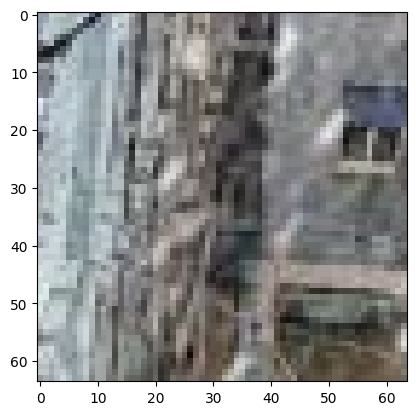

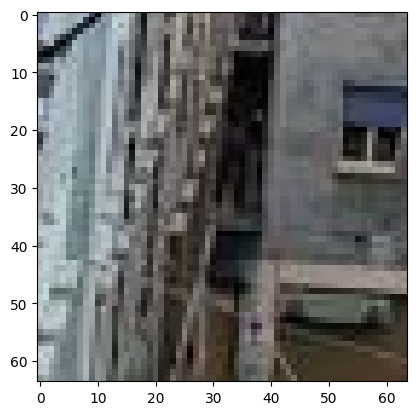

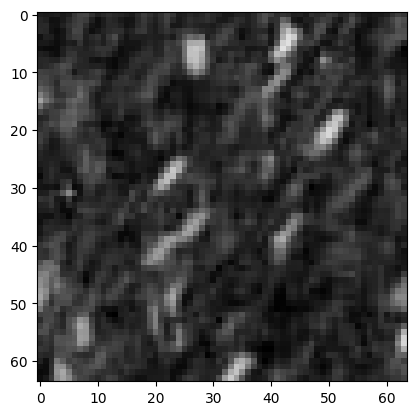

In [ ]:
print("Original Input")
plt.figure()
grid = utils.make_grid(croppedImgsSnow)
plt.imshow(grid.cpu().detach().numpy().transpose((1, 2, 0)))
plt.figure()
grid = utils.make_grid(croppedImgsOrig)
plt.imshow(grid.cpu().detach().numpy().transpose((1, 2, 0)))
plt.figure()
grid = utils.make_grid(croppedImgsMask)
plt.imshow(grid.cpu().detach().numpy().transpose((1, 2, 0)))

Inference Results


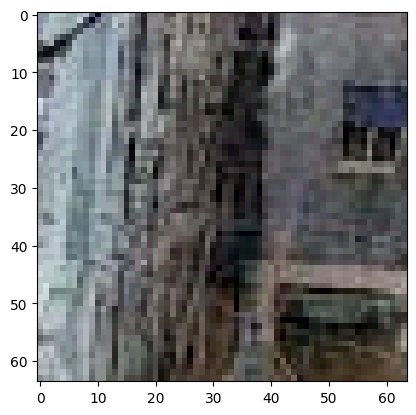

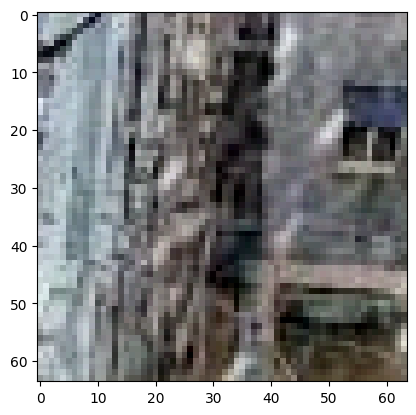

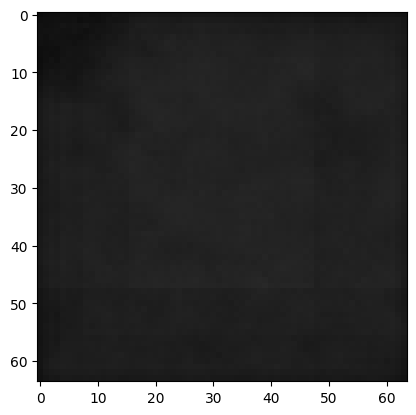

In [ ]:
print("Inference Results")
plt.figure()
grid = utils.make_grid(y_hat)
plt.imshow(grid.cpu().detach().numpy().transpose((1, 2, 0)))
plt.figure()
grid = utils.make_grid(y_dash)
plt.imshow(grid.cpu().detach().numpy().transpose((1, 2, 0)))
plt.figure()
grid = utils.make_grid(z_hat)
plt.imshow(grid.cpu().detach().numpy().transpose((1, 2, 0)))


In [ ]:

def wholeImageInference(model, imSnow, tensorImgSnow):
  with torch.no_grad():
    H = imSnow.shape[0]
    W = imSnow.shape[1]
    patchSize = 64
    model.eval()
    deSnowImage = torch.zeros(tensorImgSnow.shape)
    deSnowImage = deSnowImage.cpu()
    for i in range(0, W, patchSize):
      for j in range(0, H-64, patchSize):
        torch.cuda.empty_cache()
        croppedI = tf.crop(tensorImgSnow, j, i, patchSize, patchSize)
        croppedI = croppedI.to(device)
        y_hat, y_dash, z_hat = model(torch.unsqueeze(croppedI, 0))
        torch.cuda.synchronize()
        y_hat = y_hat.cpu()
        deSnowImage[:, j:j+patchSize, i:i+patchSize] = y_hat
        torch.cuda.synchronize()
        croppedI = croppedI.to("cpu")

    plt.figure()
    grid = utils.make_grid(tensorImgSnow)
    plt.imshow(grid.cpu().detach().numpy().transpose((1, 2, 0)))

    plt.figure()
    grid = utils.make_grid(deSnowImage)
    plt.imshow(grid.cpu().detach().numpy().transpose((1, 2, 0)))



In [ ]:
imName = "beautiful_smile_00049.jpg"
folderName = "snow"


imageSnowName = folderName+"/synthetic/"+imName
imageOrigName = folderName+"/gt/"+imName
imageMaskName = folderName+"/mask/"+imName
imSnow = cv2.imread(imageSnowName)
imOrig = cv2.imread(imageOrigName)
imMask = cv2.imread(imageMaskName)
imSnow = cv2.cvtColor(imSnow, cv2.COLOR_BGR2RGB)
imOrig = cv2.cvtColor(imOrig, cv2.COLOR_BGR2RGB)
imMask = cv2.cvtColor(imMask, cv2.COLOR_BGR2RGB)
# # To Tensor
tensorImgSnow = tf.to_tensor(imSnow)
tensorImgOrig = tf.to_tensor(imOrig)
tensorImgMask = tf.to_tensor(imMask)

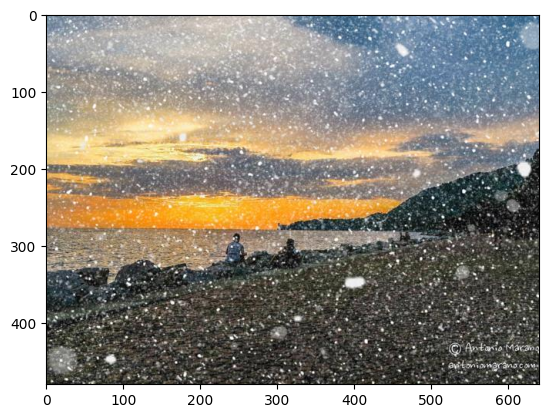

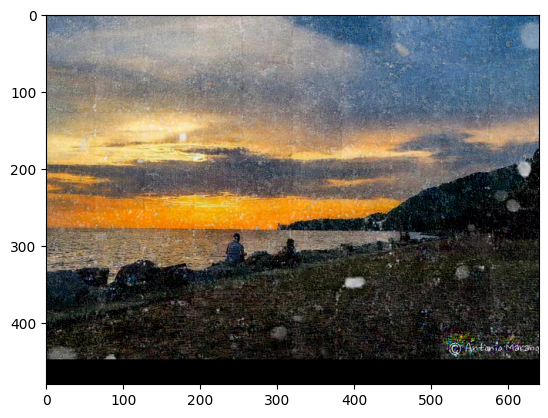

In [ ]:
wholeImageInference(model, imSnow, tensorImgSnow)